In [38]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate
import pandas as pd
import random
from nemo import NemoSolver
import os
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [2]:
# Specify the directory path
directory_path = 'datasets/RIPEAtlas/02072023/coords/'

# Iterate over all files in the directory
coord_dict = {}
for filename in os.listdir(directory_path):
    # Check if it's a file (not a directory)
    file = os.path.join(directory_path, filename)
    if os.path.isfile(file):
        df = topology.coords_ripe_atlas(file)
        # df["x"] = df["x"] - df["x"].mean()
        # df["y"] = df["y"] - df["y"].mean()

        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - df.loc[0, ["x", "y"]].to_numpy()))
        f = filename.replace(".csv", "")
        f = int(f.replace("time-", ""))
        coord_dict[f] = df

coord_list = []
coord_mean = coord_dict[0][["x", "y"]].copy()
for i in sorted(coord_dict.keys()):
    coord_list.append(coord_dict[i])
    if i > 0:
        coord_mean["x"] += coord_dict[i]["x"]
        coord_mean["y"] += coord_dict[i]["y"]
coord_mean["x"] = coord_mean["x"] / len(coord_dict)
coord_mean["y"] = coord_mean["y"] / len(coord_dict)
coord_mean['latency'] = list(zip(coord_mean.x, coord_mean.y))
coord_mean['latency'] = coord_mean['latency'].apply(
    lambda x: np.linalg.norm(x - coord_mean.loc[0, ["x", "y"]].to_numpy()))

t_label = 0
coords_df = coord_dict[t_label]
s_dict = {t_label: coord_mean}
avg = 50
c_capacity = 50
seed = 10
H, bins = get_lognorm_hist()

device_number = coords_df.shape[0]
max_resources = device_number * avg - c_capacity

df_dict_topologies = topology.create_topologies_from_dict(s_dict, H, max_resources, c_capacity,
                                                          weights=(1, avg * 2), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=seed)
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
prim_df["weight_1"] = 1
num_clusters = prim_df["cluster"].nunique() - 1
prim_df

sigma: [1.41161381] scale: [7.33497171]
Creating df for 0
Optimal k is 10
Done


,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster,weight_1
0,308.494393,272.860026,0.000000,coordinator,398161,0,50,50,50,50,50,50,50,50,50,50,50,50,-1,1
1,316.976824,275.994535,9.043051,worker,398161,1,50,50,50,58,40,68,42,34,123,17,267,16,1,1
2,282.361038,258.647238,29.748203,worker,398161,6,50,49,55,42,53,58,68,32,25,62,17,28,1,1
3,306.501880,265.083892,8.027351,worker,398161,1,50,48,50,54,49,56,38,38,33,17,51,48,1,1
4,298.626985,272.848666,9.867415,worker,398161,1,50,50,54,56,49,56,80,76,93,19,23,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,306.716136,272.192946,1.899262,worker,398161,4,50,53,50,44,40,47,40,45,31,42,17,24,1,1
627,576.843206,381.661311,289.566581,worker,398161,1,50,49,56,46,63,57,52,42,71,22,82,20,7,1
628,435.369979,402.392926,181.317915,worker,398161,2,50,49,53,58,39,45,42,35,28,24,68,339,2,1
629,601.380349,374.773278,310.110455,worker,398161,2,50,50,48,44,58,44,42,43,33,33,43,0,7,1


In [3]:
coord_mean

,x,y,latency
0,308.494393,272.860026,0.000000
1,316.976824,275.994535,9.043051
2,282.361038,258.647238,29.748203
3,306.501880,265.083892,8.027351
4,298.626985,272.848666,9.867415
...,...,...,...
626,306.716136,272.192946,1.899262
627,576.843206,381.661311,289.566581
628,435.369979,402.392926,181.317915
629,601.380349,374.773278,310.110455


In [4]:
coord_dict[0]

,x,y,latency
0,-75.830277,52.683942,0.000000
1,-42.265554,59.965194,34.345411
2,-68.493981,9.120721,44.176640
3,-99.443849,25.313260,36.149067
4,-94.569935,-10.751235,66.145268
...,...,...,...
626,-129.978419,32.805344,57.681712
627,184.342454,203.354003,300.651489
628,-11.243729,216.694522,176.269375
629,178.467782,231.397961,310.815385


In [5]:
coord_dict.keys()

dict_keys([16, 8, 0, 2, 18, 22, 14, 4, 11, 21, 20, 1, 3, 9, 17, 13, 15, 5, 12, 19, 10, 23, 6, 7])

In [6]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 4220 Available: 31550


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

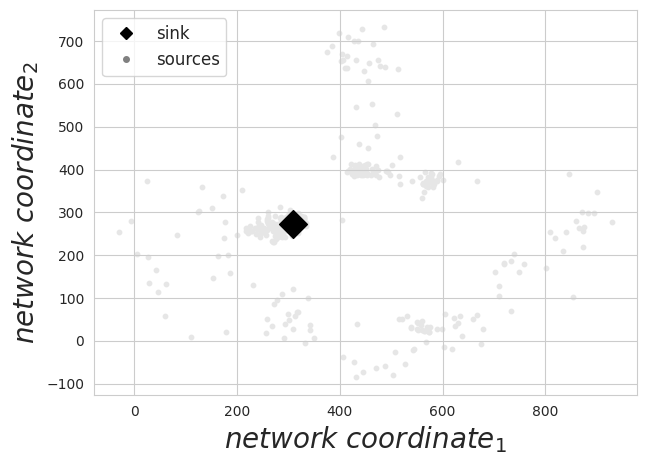

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

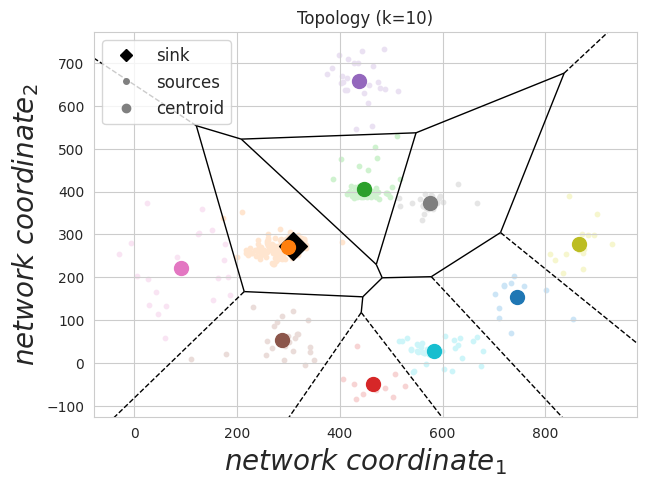

In [8]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

## Comparison of Latencies

In [98]:
param_dict = {
    "weight_1": {"merge_factor": 0.2, "step_size": 0.2},
    "weight_2": {"merge_factor": 0.2, "step_size": 0.2},
    "weight": {"merge_factor": 0.2, "step_size": 0.2},
}

In [99]:
df_rtt_list = []
for i in range(0, 24):
    df_rtt = pd.read_csv(f"datasets/RIPEAtlas/02072023/rtt_matrix/time-{i}.csv", sep=",")
    df_rtt.columns = range(0, len(df_rtt.columns))
    df_rtt_list.append(df_rtt)
df_rtt = df_rtt_list[0]

In [100]:
len(df_rtt_list)

24

In [101]:
df_rtt

,0,1,2,3,4,5,6,7,8,9,...,621,622,623,624,625,626,627,628,629,630
0,0,20,58,37,38,62,394,392,175,31,...,22,272,33,175,32,33,289,172,321,44
1,20,0,41,33,37,43,337,372,182,20,...,4,257,33,153,36,21,408,172,289,4
2,58,41,0,9,48,58,536,413,259,44,...,53,328,24,223,10,42,308,218,375,49
3,37,33,9,0,41,58,506,408,187,18,...,37,288,10,198,1,30,302,193,294,36
4,38,37,48,41,0,65,406,399,333,26,...,41,277,55,225,47,34,286,269,336,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,33,21,42,30,34,56,430,384,195,23,...,21,289,20,193,37,0,372,185,339,21
627,289,408,308,302,286,304,403,635,143,314,...,274,41,448,142,736,372,0,126,34,275
628,172,172,218,193,269,194,288,514,43,185,...,177,131,186,24,199,185,126,0,167,177
629,321,289,375,294,336,348,433,653,132,327,...,316,8,364,158,356,339,34,167,0,302


In [102]:
ndf = prim_df.copy()
i = 0
slot_col = "capacity_100"
weight_col = "weight_1"

ndf["x"] = coord_list[i]["x"]
ndf["y"] = coord_list[i]["y"]
ndf["latency"] = coord_list[i]["latency"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df)
edf

Level 0 CH number:  630 Load: 630
--------Balancing load for 10 clusters to 0
Level 1 CH number:  19 Load: 19


,latency_distribution,received_packets
0,0.000000,19.0
247,19.018672,48.0
352,215.223352,22.0
135,419.602339,10.0
606,364.312465,9.0
...,...,...
215,82.547758,0.0
216,62.498716,0.0
217,402.999004,0.0
218,52.487363,0.0


In [103]:
edf2 = util.evaluate(df, df_rtt)
edf2

,latency_distribution,received_packets
0,0.0,19.0
247,22.0,48.0
352,190.0,22.0
135,438.0,10.0
606,368.0,9.0
...,...,...
215,99.0,0.0
216,67.0,0.0
217,367.0,0.0
218,98.0,0.0


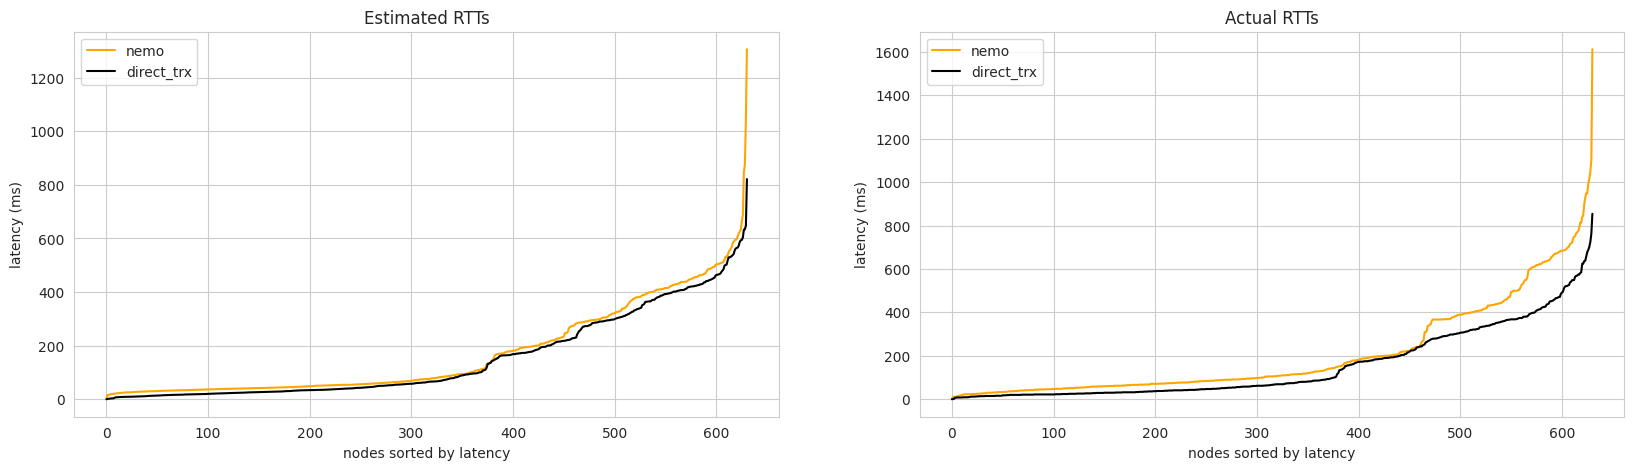

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)

sv_orig = edf["latency_distribution"].sort_values()
sv_orig.plot(ax=ax1, use_index=False, label="nemo", color="orange")

sv_direct_trx = coord_dict[0]["latency"].sort_values()
sv_direct_trx.plot(ax=ax1, use_index=False, label="direct_trx", color="black")

sv_rtt = edf2["latency_distribution"].sort_values()
sv_rtt.plot(ax=ax2, use_index=False, label="nemo", color="orange")

sv_rtt_direct_trx = df_rtt.loc[0].sort_values()
sv_rtt_direct_trx.plot(ax=ax2, use_index=False, label="direct_trx", color="black")

ax1.set_title('Estimated RTTs')
ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=1)

ax2.set_title('Actual RTTs')
ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=1)

plt.show()

## Changing Topology

In [105]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_1"
weight_col = "weight"
coord_list_mean = [coord_list[0]]

df = prim_df.copy()
df["x"] = coord_list[0]["x"]
df["y"] = coord_list[0]["y"]
df["latency"] = coord_list[0]["latency"]

evaluations = []
evaluations_sl = {}
evaluations_full = []
placement_df = None
df_sum = df
df_sum["x"] = coord_list[0]["x"]
df_sum["y"] = coord_list[0]["y"]
df_sum['latency'] = coord_list[0]["latency"]

for i, coords_df in enumerate(coord_list):
    if i > 0:
        df_sum["x"] += coords_df["x"]
        df_sum["y"] += coords_df["y"]
        df = df_sum.copy()
        df["x"] = df["x"] / i
        df["y"] = df["y"] / i
        df['latency'] = list(zip(df.x, df.y))
        df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - df.loc[0, ["x", "y"]].to_numpy()))
        coord_list_mean.append(df[["x", "y", "latency"]].copy())
        # df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)

    if i == 0:
        sl = ["capacity_100", "capacity_1"]
    else:
        sl = [slot_col]
    eval_matrix, df_dict, opt_dict, limits_dict = evaluate_nemo(df, sl, weight_col,
                                                                merge_factor=param_dict[weight_col][
                                                                    "merge_factor"],
                                                                step_size=param_dict[weight_col]["step_size"],
                                                                with_eval=True, df_rtt=df_rtt_list[i])
    if i == 0:
        placement_dict = df_dict
        placement_df = df_dict[slot_col].copy()

    if limits_dict[slot_col] == True:
        print("Overloaded!")
        break

    evaluations_full.append(eval_matrix[slot_col])

    if i > 0:
        update_df = coords_df[["x", "y"]]
        # df = util.update_coordinates(placement_df, update_df)
        edf = evaluate(placement_df, df_rtt=df_rtt_list[i])
        evaluations_sl[i] = {}
        for sl in ["capacity_100", "capacity_1"]:
            print("Evaluating", i, sl)
            evaluations_sl[i][sl] = evaluate(placement_dict[sl], df_rtt=df_rtt_list[i])
    else:
        edf = eval_matrix[slot_col]
        evaluations_sl[i] = eval_matrix
    evaluations.append(edf)

Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630 Load: 4220
--------Balancing load for 10 clusters to 0
Level 1 CH number:  90 Load: 497
--------Balancing load for 2 clusters to 0
Level 2 CH number:  11 Load: 103
--------Balancing load for 1 clusters to 0
Level 3 CH number:  3 Load: 9
Evaluating for capacity_100
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630 Load: 4220
--------Balancing load for 10 clusters to 0
Level 1 CH number:  84 Load: 474
--------Balancing load for 2 clusters to 0
Level 2 CH number:  15 Load: 95
--------Balancing load for 1 clusters to 0
Level 3 CH number:  3 Load: 10
Evaluating for capacity_1
Starting nemo for: c=capacity_1, w=weight, l=20, step_size=0.2, merge_factor=0.2
Level 0 CH number:  630 Load: 4220
--------Balancing load for 10 clusters to 0
Level 1 CH number:  94 Load: 609
--------Balancing load for 2 clusters to 0
Level 2 CH number:  12 L

## Evaluation

#### Latency

In [106]:
colors, light_colors, palette = util.get_color_list(11)

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


Means re: {'0': 359.13, '1': 326.3, '2': 295.12, '3': 325.94, '4': 300.02, '5': 253.27, '6': 282.56, '7': 282.66, '8': 269.64, '9': 265.08, '10': 291.63, '11': 275.96, '12': 422.95, '13': 332.58, '14': 260.42, '15': 500.76, '16': 503.56, '17': 266.03, '18': 261.39, '19': 376.69, '20': 276.09, '21': 476.43, '22': 274.08, '23': 277.05}
Quantiles re: {'0': 744.0, '1': 737.0, '2': 706.0, '3': 750.0, '4': 765.0, '5': 573.0, '6': 622.0, '7': 643.0, '8': 666.0, '9': 614.0, '10': 627.0, '11': 618.0, '12': 735.0, '13': 576.0, '14': 618.0, '15': 755.0, '16': 776.0, '17': 579.0, '18': 565.0, '19': 671.0, '20': 663.0, '21': 731.67, '22': 579.0, '23': 609.0}


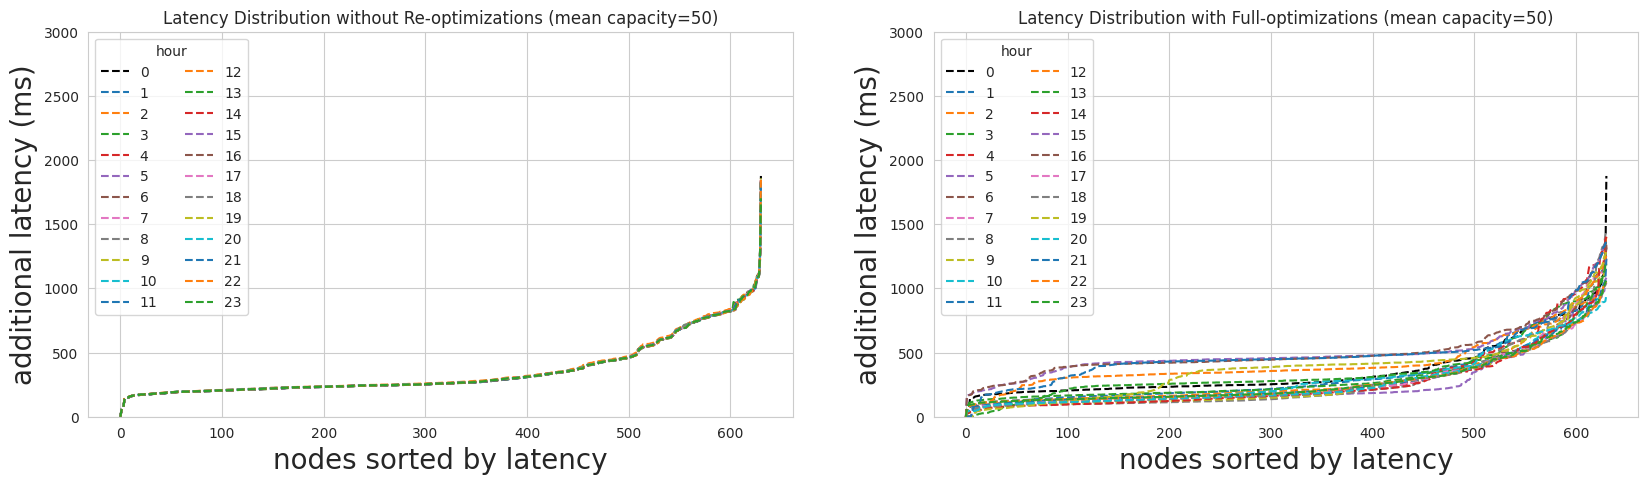

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
eval_dict_no = {}

quant_dict_re = {}
mean_dict_re = {}

prim_eval = coord_dict[t_label]["latency"]
nodes_take = 50
changed_nodes = {}

sl_plot = "capacity_1"

for i in range(len(evaluations)):
    l = str(i)
    eval_dict_no[i] = {}
    for sl in ["capacity_1", "capacity_100"]:
        eval_df = evaluations_sl[i][sl]
        sv = eval_df.sort_index()["latency_distribution"]
        sv = sv.sort_values()
    
        res = {"90": round(sv.quantile(0.9), 2), 
               "80": round(sv.quantile(0.8), 2), 
               "70": round(sv.quantile(0.7), 2),
               "mean": round(sv.mean(), 2)}
        eval_dict_no[i][sl] = res
        
    eval_df = evaluations_sl[i][sl_plot]
    sv = eval_df.sort_index()["latency_distribution"]
    sv = sv.sort_values()

    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:])  # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

    sv1 = evaluations_full[i].sort_index()["latency_distribution"]
    sv = sv1  # - sv2
    sv = sv.sort_values()
    quant_dict_re[l] = round(sv.quantile(0.9), 2)
    mean_dict_re[l] = round(sv.mean(), 2)

    if i > 0:
        changed_nodes[i] = list(sv.index[-nodes_take:])  # Get the last 100 indexes

    if i == 0:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--", color="black")
    else:
        sv.plot(ax=ax2, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')
ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")

ax2.set_xlabel('nodes sorted by latency')
ax2.set_ylabel('additional latency (ms)')
ax2.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.set_ylim([0, 3000])
ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)
ax2.yaxis.label.set_size(20)
ax2.xaxis.label.set_size(20)
ylim_orig = ax1.get_ylim()
ax2.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

print("Means re:", mean_dict_re)
print("Quantiles re:", quant_dict_re)

ax1.set_title('Latency Distribution without Re-optimizations (mean capacity=' + str(avg) + ")")
ax2.set_title('Latency Distribution with Full-optimizations (mean capacity=' + str(avg) + ")")
plt.show()

In [109]:
eval_dict_no

{0: {'capacity_1': {'90': 744.0, '80': 469.0, '70': 353.75, 'mean': 359.13},
  'capacity_100': {'90': 647.0, '80': 387.0, '70': 299.0, 'mean': 276.33}},
 1: {'capacity_1': {'90': 743.0, '80': 469.0, '70': 357.0, 'mean': 359.28},
  'capacity_100': {'90': 643.0, '80': 386.0, '70': 302.0, 'mean': 275.87}},
 2: {'capacity_1': {'90': 746.0, '80': 477.0, '70': 353.75, 'mean': 359.49},
  'capacity_100': {'90': 648.0, '80': 386.0, '70': 298.0, 'mean': 276.16}},
 3: {'capacity_1': {'90': 745.0, '80': 467.0, '70': 356.0, 'mean': 360.37},
  'capacity_100': {'90': 658.5, '80': 394.0, '70': 300.0, 'mean': 279.76}},
 4: {'capacity_1': {'90': 743.0, '80': 474.0, '70': 356.0, 'mean': 358.66},
  'capacity_100': {'90': 661.0, '80': 397.0, '70': 302.0, 'mean': 276.84}},
 5: {'capacity_1': {'90': 745.0, '80': 474.0, '70': 356.5, 'mean': 358.25},
  'capacity_100': {'90': 640.0, '80': 407.0, '70': 300.0, 'mean': 276.6}},
 6: {'capacity_1': {'90': 745.0, '80': 476.0, '70': 353.62, 'mean': 357.68},
  'capacit

## Test Reoptimization

In [138]:
re_evaluations = []
ndf = prim_df.copy()
i = 0
ndf["x"] = coord_list_mean[i]["x"]
ndf["y"] = coord_list_mean[i]["y"]
ndf["latency"] = coord_list_mean[i]["latency"]

nemo = NemoSolver(ndf, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                  merge_factor=param_dict[weight_col]["merge_factor"])
df, opts, limits = nemo.nemo_full()

edf = util.evaluate(df, df_rtt=df_rtt_list[0])
re_evaluations.append(edf)
print(df["oindex"].nunique())
df

Level 0 CH number:  630 Load: 630
--------Balancing load for 10 clusters to 0
Level 1 CH number:  19 Load: 19
631


,oindex,x,y,type,cluster,total_weight,unbalanced_weight,used_weight,total_capacity,free_capacity,level,parent,load
0,0,-75.830277,52.683942,coordinator,-1,<NA>,<NA>,<NA>,50,31,2,<NA>,19
1,1,-42.265554,59.965194,worker,1,1,0,1,50,50,0,454,0
2,2,-68.493981,9.120721,worker,1,1,0,1,50,50,0,143,0
3,3,-99.443849,25.313260,worker,1,1,0,1,50,50,0,454,0
4,4,-94.569935,-10.751235,worker,1,1,0,1,50,50,0,342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,626,-129.978419,32.805344,worker,1,1,0,1,50,50,0,342,0
627,627,184.342454,203.354003,worker,7,1,0,1,50,50,0,350,0
628,628,-11.243729,216.694522,worker,2,1,0,1,50,50,0,390,0
629,629,178.467782,231.397961,worker,7,1,0,1,50,50,0,350,0


In [139]:
coord_list[1]

,x,y,latency,cluster
0,-170.192825,79.036054,0.000000,-1
1,-68.129672,120.128813,110.025006,1
2,-132.697285,63.777314,40.481411,1
3,-130.788623,117.278081,54.910324,1
4,-149.470083,26.342509,56.621918,5
...,...,...,...,...
626,-167.220869,100.204310,21.375865,1
627,336.713476,517.644381,670.321761,9
628,53.961477,448.116278,431.816353,2
629,371.346621,534.586868,707.666246,9


In [140]:
df_re = df
k_neigh = 400
coord_list = coord_list_mean
root_df = coord_list[0]

for i in range(1, len(evaluations)):
    nodes = changed_nodes[i]
    nodes = set(nodes).intersection(df_re["oindex"].unique())
    nodes = list(nodes)
    print("Iteration", i, "Nodes", nodes)
    # update_df, centroids, opt_k, sil = topology.add_kmeans_labels(coord_list[i], kmin=num_clusters, kmax=num_clusters, kseed=seed)
    # coords = coord_list
    # nemo.update_coordinates(update_df)
    df_re, opt_dict, resource_limit, level = nemo.remove_nodes(nodes, step_size=0.1, merge_factor=0.3)

    new_nodes = list()
    for node_idx in nodes:
        node = prim_df.loc[node_idx].to_dict()
        new_distances_df = coord_list[i]
        #n_coords, error = util.fit_coords(node_idx, root_df, new_distances_df, k_neigh)
        node["x"] = coord_list[i].loc[node_idx, "x"]  #n_coords[0]
        node["y"] = coord_list[i].loc[node_idx, "y"]  #n_coords[1]
        node["capacity"] = node[slot_col]
        node["weight"] = node[weight_col]
        node["oindex"] = node_idx
        new_nodes.append(node)
        # new_idx, df_re, resource_limit = nemo.add_node(node)
    df_re, opt_dict, resource_limit, level = nemo.add_nodes(new_nodes, full_opt=True, k_cluster_opt=4)
    if resource_limit:
        break
        print("----------------Resource limit reached. Init full opt")
        df = prim_df.copy()
        coords_df = coord_list[i]

        df["x"] = coords_df["x"]
        df["y"] = coords_df["y"]
        df["latency"] = coords_df["latency"]
        df, centroids, opt_k, sil = topology.add_kmeans_labels(df, kmin=num_clusters, kmax=num_clusters, kseed=seed)

        nemo = NemoSolver(df, slot_col, weight_col, max_levels=50, step_size=param_dict[weight_col]["step_size"],
                          merge_factor=param_dict[weight_col]["merge_factor"])
        df_re, opts, resource_limit = nemo.nemo_full()

        if resource_limit:
            print("Resource Limit!!!!!!!!!")
            break

    update_df = coord_list[i][["x", "y"]]
    df = util.update_coordinates(df_re, update_df)
    edf = evaluate(df)
    re_evaluations.append(edf)

Iteration 1 Nodes [256, 386, 514, 515, 6, 7, 393, 398, 399, 400, 401, 274, 533, 278, 151, 407, 534, 413, 414, 541, 544, 418, 548, 424, 302, 310, 183, 566, 316, 579, 324, 453, 326, 76, 81, 595, 469, 470, 94, 223, 606, 611, 228, 357, 231, 620, 493, 114, 117, 503]
Node with ID [606] are cluster head. Re-optimizing children with level 0: {3: [545, 195, 429]}
Level 0 CH number:  3 Load: 3
re-optimizing clusters dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Level 0 CH number:  630 Load: 630
--------Balancing load for 10 clusters to 0
Level 1 CH number:  18 Load: 18
Iteration 2 Nodes [256, 386, 514, 515, 6, 7, 141, 398, 399, 400, 401, 533, 278, 151, 407, 534, 413, 414, 541, 544, 418, 548, 302, 566, 183, 446, 449, 578, 579, 324, 326, 76, 81, 213, 469, 470, 94, 223, 611, 228, 357, 231, 492, 620, 493, 114, 117, 502, 503, 381]
re-optimizing clusters dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Level 0 CH number:  630 Load: 630
--------Balancing load for 10 clusters to 0
Level 1 CH number:  18 Load: 18
I

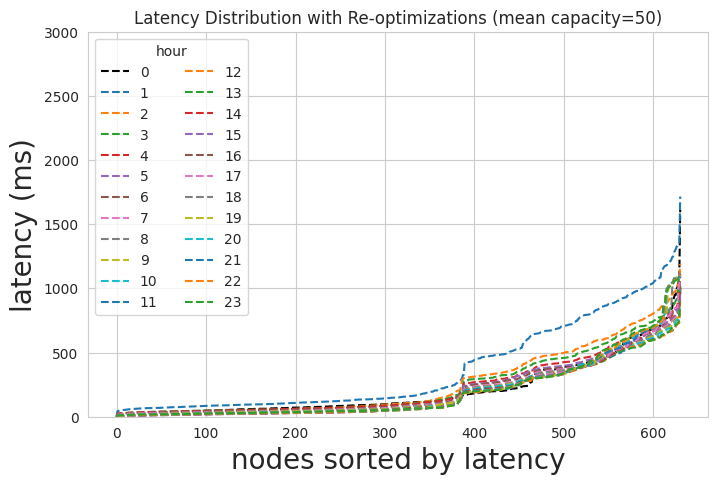

Means:  {'0': 211.46, '1': 366.59, '2': 256.76, '3': 241.64, '4': 225.29, '5': 208.47, '6': 205.67, '7': 196.86, '8': 192.18, '9': 188.13, '10': 184.42, '11': 177.63, '12': 176.28, '13': 176.56, '14': 182.75, '15': 182.12, '16': 184.03, '17': 184.95, '18': 191.93, '19': 193.41, '20': 193.15, '21': 192.71, '22': 193.83, '23': 197.1}
Quantiles:  {'0': 591.0, '1': 925.34, '2': 681.01, '3': 647.17, '4': 587.2, '5': 550.78, '6': 543.77, '7': 529.72, '8': 534.3, '9': 538.26, '10': 523.82, '11': 514.33, '12': 531.81, '13': 521.54, '14': 541.1, '15': 535.98, '16': 541.08, '17': 536.55, '18': 586.51, '19': 579.48, '20': 572.85, '21': 560.23, '22': 586.35, '23': 603.57}


In [141]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

for i in range(len(re_evaluations)):
    l = str(i)
    sv1 = re_evaluations[i].sort_index()["latency_distribution"]
    sv = sv1
    sv = sv.sort_values()

    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv = sv.to_numpy()

    if i == 0:
        ax1.plot(sv, label=l, linestyle="--", color="black")
    else:
        ax1.plot(sv, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10}, ncol=2, title="hour")
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

ax1.set_ylim(ylim_orig)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution with Re-optimizations (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [110]:
eval_dict_no_w1 = {0: {'capacity_1': {'90': 610.0, '80': 378.0, '70': 219.0, 'mean': 215.05},
  'capacity_100': {'90': 591.0, '80': 394.0, '70': 216.0, 'mean': 211.46}},
 1: {'capacity_1': {'90': 621.0, '80': 378.0, '70': 222.0, 'mean': 220.42},
  'capacity_100': {'90': 599.0, '80': 438.0, '70': 237.0, 'mean': 220.56}},
 2: {'capacity_1': {'90': 611.0, '80': 378.0, '70': 223.0, 'mean': 217.64},
  'capacity_100': {'90': 591.0, '80': 438.0, '70': 239.0, 'mean': 217.08}},
 3: {'capacity_1': {'90': 632.0, '80': 404.0, '70': 223.0, 'mean': 222.92},
  'capacity_100': {'90': 602.0, '80': 438.0, '70': 240.0, 'mean': 227.43}},
 4: {'capacity_1': {'90': 629.0, '80': 379.0, '70': 235.0, 'mean': 221.71},
  'capacity_100': {'90': 600.0, '80': 437.0, '70': 239.0, 'mean': 223.98}},
 5: {'capacity_1': {'90': 610.0, '80': 392.0, '70': 230.0, 'mean': 255.1},
  'capacity_100': {'90': 600.0, '80': 438.0, '70': 240.0, 'mean': 226.6}},
 6: {'capacity_1': {'90': 603.0, '80': 415.0, '70': 222.0, 'mean': 220.01},
  'capacity_100': {'90': 596.0, '80': 439.0, '70': 239.0, 'mean': 224.68}},
 7: {'capacity_1': {'90': 599.0, '80': 392.0, '70': 219.0, 'mean': 217.95},
  'capacity_100': {'90': 591.0, '80': 442.0, '70': 216.0, 'mean': 215.35}},
 8: {'capacity_1': {'90': 601.0, '80': 378.0, '70': 219.0, 'mean': 213.66},
  'capacity_100': {'90': 581.0, '80': 392.0, '70': 216.0, 'mean': 209.14}},
 9: {'capacity_1': {'90': 596.0, '80': 377.0, '70': 219.0, 'mean': 212.66},
  'capacity_100': {'90': 578.0, '80': 397.0, '70': 215.0, 'mean': 207.71}},
 10: {'capacity_1': {'90': 598.0, '80': 366.0, '70': 220.0, 'mean': 210.16},
  'capacity_100': {'90': 574.0, '80': 345.0, '70': 207.0, 'mean': 202.06}},
 11: {'capacity_1': {'90': 599.0, '80': 366.0, '70': 220.0, 'mean': 208.88},
  'capacity_100': {'90': 574.0, '80': 345.0, '70': 214.0, 'mean': 202.28}},
 12: {'capacity_1': {'90': 601.0, '80': 366.0, '70': 222.0, 'mean': 209.54},
  'capacity_100': {'90': 574.0, '80': 337.0, '70': 217.0, 'mean': 202.63}},
 13: {'capacity_1': {'90': 603.0, '80': 366.0, '70': 219.0, 'mean': 209.58},
  'capacity_100': {'90': 575.0, '80': 338.0, '70': 214.0, 'mean': 202.85}},
 14: {'capacity_1': {'90': 603.0, '80': 366.0, '70': 219.0, 'mean': 209.73},
  'capacity_100': {'90': 585.0, '80': 365.0, '70': 216.0, 'mean': 205.04}},
 15: {'capacity_1': {'90': 603.0, '80': 366.0, '70': 219.0, 'mean': 208.79},
  'capacity_100': {'90': 572.0, '80': 343.0, '70': 213.0, 'mean': 201.56}},
 16: {'capacity_1': {'90': 599.0, '80': 365.0, '70': 221.0, 'mean': 209.1},
  'capacity_100': {'90': 572.0, '80': 337.0, '70': 216.0, 'mean': 201.58}},
 17: {'capacity_1': {'90': 603.0, '80': 366.0, '70': 219.0, 'mean': 209.25},
  'capacity_100': {'90': 575.0, '80': 341.0, '70': 212.0, 'mean': 202.51}},
 18: {'capacity_1': {'90': 596.0, '80': 366.0, '70': 220.0, 'mean': 209.86},
  'capacity_100': {'90': 573.0, '80': 362.0, '70': 218.0, 'mean': 204.5}},
 19: {'capacity_1': {'90': 605.0, '80': 365.0, '70': 219.0, 'mean': 208.92},
  'capacity_100': {'90': 578.0, '80': 339.0, '70': 212.0, 'mean': 202.06}},
 20: {'capacity_1': {'90': 632.0, '80': 366.0, '70': 219.0, 'mean': 211.77},
  'capacity_100': {'90': 632.0, '80': 344.0, '70': 216.0, 'mean': 212.2}},
 21: {'capacity_1': {'90': 616.0, '80': 366.0, '70': 219.0, 'mean': 209.03},
  'capacity_100': {'90': 604.0, '80': 344.0, '70': 212.0, 'mean': 203.99}},
 22: {'capacity_1': {'90': 602.0, '80': 368.0, '70': 219.0, 'mean': 208.98},
  'capacity_100': {'90': 600.0, '80': 346.0, '70': 214.0, 'mean': 205.93}},
 23: {'capacity_1': {'90': 604.0, '80': 365.0, '70': 219.0, 'mean': 209.28},
  'capacity_100': {'90': 582.0, '80': 337.0, '70': 212.0, 'mean': 202.42}}}

In [111]:
eval_dict_no_w = {0: {'capacity_1': {'90': 744.0, '80': 469.0, '70': 353.75, 'mean': 359.13},
  'capacity_100': {'90': 647.0, '80': 387.0, '70': 299.0, 'mean': 276.33}},
 1: {'capacity_1': {'90': 743.0, '80': 469.0, '70': 357.0, 'mean': 359.28},
  'capacity_100': {'90': 643.0, '80': 386.0, '70': 302.0, 'mean': 275.87}},
 2: {'capacity_1': {'90': 746.0, '80': 477.0, '70': 353.75, 'mean': 359.49},
  'capacity_100': {'90': 648.0, '80': 386.0, '70': 298.0, 'mean': 276.16}},
 3: {'capacity_1': {'90': 745.0, '80': 467.0, '70': 356.0, 'mean': 360.37},
  'capacity_100': {'90': 658.5, '80': 394.0, '70': 300.0, 'mean': 279.76}},
 4: {'capacity_1': {'90': 743.0, '80': 474.0, '70': 356.0, 'mean': 358.66},
  'capacity_100': {'90': 661.0, '80': 397.0, '70': 302.0, 'mean': 276.84}},
 5: {'capacity_1': {'90': 745.0, '80': 474.0, '70': 356.5, 'mean': 358.25},
  'capacity_100': {'90': 640.0, '80': 407.0, '70': 300.0, 'mean': 276.6}},
 6: {'capacity_1': {'90': 745.0, '80': 476.0, '70': 353.62, 'mean': 357.68},
  'capacity_100': {'90': 638.0, '80': 396.0, '70': 299.0, 'mean': 274.71}},
 7: {'capacity_1': {'90': 743.0, '80': 466.25, '70': 354.38, 'mean': 358.12},
  'capacity_100': {'90': 639.0, '80': 395.0, '70': 298.0, 'mean': 274.74}},
 8: {'capacity_1': {'90': 744.0, '80': 473.75, '70': 353.12, 'mean': 357.79},
  'capacity_100': {'90': 638.0, '80': 389.0, '70': 294.0, 'mean': 274.29}},
 9: {'capacity_1': {'90': 743.0, '80': 475.0, '70': 356.0, 'mean': 358.48},
  'capacity_100': {'90': 642.0, '80': 394.0, '70': 296.0, 'mean': 275.02}},
 10: {'capacity_1': {'90': 744.0, '80': 468.0, '70': 353.75, 'mean': 357.97},
  'capacity_100': {'90': 638.0, '80': 395.0, '70': 295.0, 'mean': 274.84}},
 11: {'capacity_1': {'90': 742.0, '80': 468.0, '70': 356.0, 'mean': 358.04},
  'capacity_100': {'90': 639.0, '80': 387.0, '70': 300.0, 'mean': 274.65}},
 12: {'capacity_1': {'90': 757.0, '80': 484.0, '70': 364.0, 'mean': 366.23},
  'capacity_100': {'90': 642.0, '80': 387.0, '70': 300.0, 'mean': 275.57}},
 13: {'capacity_1': {'90': 743.0, '80': 468.0, '70': 357.0, 'mean': 357.69},
  'capacity_100': {'90': 642.0, '80': 386.0, '70': 295.0, 'mean': 274.8}},
 14: {'capacity_1': {'90': 746.0, '80': 468.0, '70': 355.0, 'mean': 358.08},
  'capacity_100': {'90': 640.0, '80': 388.0, '70': 297.0, 'mean': 275.7}},
 15: {'capacity_1': {'90': 745.0, '80': 475.5, '70': 356.62, 'mean': 358.22},
  'capacity_100': {'90': 640.0, '80': 399.33, '70': 294.0, 'mean': 274.33}},
 16: {'capacity_1': {'90': 745.0, '80': 480.0, '70': 359.0, 'mean': 359.84},
  'capacity_100': {'90': 639.0, '80': 389.0, '70': 295.0, 'mean': 274.92}},
 17: {'capacity_1': {'90': 746.0, '80': 474.0, '70': 356.12, 'mean': 359.24},
  'capacity_100': {'90': 639.0, '80': 386.0, '70': 294.0, 'mean': 274.41}},
 18: {'capacity_1': {'90': 745.0, '80': 471.0, '70': 358.0, 'mean': 360.78},
  'capacity_100': {'90': 637.0, '80': 386.0, '70': 295.0, 'mean': 273.23}},
 19: {'capacity_1': {'90': 746.0, '80': 470.0, '70': 356.0, 'mean': 358.73},
  'capacity_100': {'90': 646.0, '80': 391.0, '70': 301.0, 'mean': 279.24}},
 20: {'capacity_1': {'90': 746.0, '80': 469.0, '70': 359.0, 'mean': 359.52},
  'capacity_100': {'90': 650.0, '80': 386.0, '70': 299.0, 'mean': 278.89}},
 21: {'capacity_1': {'90': 744.0, '80': 468.5, '70': 356.0, 'mean': 358.55},
  'capacity_100': {'90': 660.0, '80': 387.0, '70': 297.0, 'mean': 276.12}},
 22: {'capacity_1': {'90': 745.0, '80': 468.0, '70': 356.0, 'mean': 358.33},
  'capacity_100': {'90': 640.0, '80': 389.0, '70': 295.0, 'mean': 275.89}},
 23: {'capacity_1': {'90': 745.0, '80': 470.0, '70': 354.62, 'mean': 359.33},
  'capacity_100': {'90': 638.0, '80': 386.0, '70': 294.0, 'mean': 274.11}}}

In [112]:
markers = {
    1: {50: "<", 25: ">"},
    2: {50: "^", 25: "v"}
}

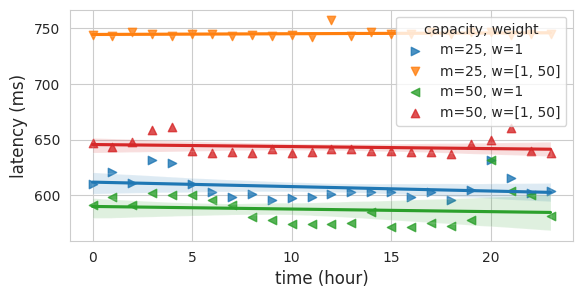

In [130]:
# Create a figure and axes for the scatter plot
fig, ax = plt.subplots(figsize=(6.5, 3))

# Assuming quants_no and quants_re are dictionaries
for capacity in ["capacity_1", "capacity_100"]:
    for quant in ["90"]:
        vals_w1 = []
        vals_w = []
        for i in range(0, 24):
            valw1 = eval_dict_no_w1[i][capacity][quant]
            vals_w1.append(valw1)
            valw = eval_dict_no_w[i][capacity][quant]
            vals_w.append(valw)
        
        if capacity == "capacity_1":
            cl = 25
        else:
            cl = 50
        sns.regplot(x=[i for i in range(len(vals_w1))], y=vals_w1, scatter=True, label=f"m={cl}, w=1", marker=markers[1][cl])
        sns.regplot(x=[i for i in range(len(vals_w))], y=vals_w, scatter=True, label=f"m={cl}, w=[1, 50]", marker=markers[2][cl])

# Set the axis labels and title
plt.xlabel('time (hour)', fontsize=12)
plt.ylabel('latency (ms)', fontsize=12)

# Set the legend
plt.legend(title="capacity, weight")

# Show the plot
plt.savefig("plots/evolution_latency_atlas.svg", bbox_inches='tight')
plt.show()